In [449]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [450]:
# Set random seed for reproducibility
np.random.seed(42)

# Constants for data simulation
N = 10000
MEAN_FFR, STD_FFR = 2.5, 0.5  # Federal funds rate mean and std dev
MEAN_UR, STD_UR = 5.0, 1.0    # Unemployment rate mean and std dev
PROB_YCI = 0.2                # Probability of yield curve inversion

In [451]:
def simulate_data(N):
    """ Generate synthetic economic data up to a specific end date """
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    N = len(dates)  # Adjust N based on the actual number of months between start and end dates
    federal_funds_rate = np.random.normal(2.5, 0.5, N)
    unemployment_rate = np.random.normal(5.0, 1.0, N)
    yield_curve_inversion = np.random.binomial(1, 0.2, N)
    VIX = np.random.normal(20, 5, N)
    BCI = np.random.normal(100, 10, N)
    CCI = np.random.normal(100, 10, N)
    GDP_growth = np.random.normal(3, 1, N)

    return pd.DataFrame({
        'Federal Funds Rate': federal_funds_rate,
        'Unemployment Rate': unemployment_rate,
        'Yield Curve Inversion': yield_curve_inversion,
        'VIX': VIX,
        'BCI': BCI,
        'CCI': CCI,
        'GDP Growth': GDP_growth
    }, index=dates)

data = simulate_data(1000)  # N is now dynamically adjusted based on date range

C:\Users\ellac\AppData\Local\Temp\ipykernel_37244\3868936447.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='M')


In [452]:
print(data.shape)  # Check the number of rows and columns in the DataFrame
print(data.head())  # Display the first few rows of the DataFrame to ensure it contains data


(288, 7)
            Federal Funds Rate  Unemployment Rate  Yield Curve Inversion  \
2000-01-31            2.748357           5.280992                      1   
2000-02-29            2.430868           4.377300                      0   
2000-03-31            2.823844           4.791878                      0   
2000-04-30            3.261515           4.506999                      1   
2000-05-31            2.382923           4.410635                      0   

                  VIX         BCI         CCI  GDP Growth  
2000-01-31  26.278781  100.786352  107.420954    2.608242  
2000-02-29  15.526963   80.017993  102.992926    2.077590  
2000-03-31  19.065642  109.163277  113.017413    4.615376  
2000-04-30  17.801345  103.464885  115.615112    2.677680  
2000-05-31  27.234889  109.980101  100.320041    4.217159  


In [453]:

# Standardizing and applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['VIX', 'BCI', 'CCI']])
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
data[['PC1', 'PC2']] = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

In [454]:
# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Fill NaNs with the median or mean
data.fillna(data.median(), inplace=True)

# Option 2: Drop rows with any NaNs
# data.dropna(inplace=True)


In [455]:
# Check for NaNs
print(data.isna().sum())

# Check for infinite values
print(data.replace([np.inf, -np.inf], np.nan).isna().sum())
print(data[['VIX', 'BCI', 'CCI']].describe())  # Check if there's variance


Federal Funds Rate         0
Unemployment Rate          0
Yield Curve Inversion      0
VIX                        0
BCI                        0
CCI                        0
GDP Growth                 0
PC1                      288
PC2                      288
dtype: int64
Federal Funds Rate         0
Unemployment Rate          0
Yield Curve Inversion      0
VIX                        0
BCI                        0
CCI                        0
GDP Growth                 0
PC1                      288
PC2                      288
dtype: int64
              VIX         BCI         CCI
count  288.000000  288.000000  288.000000
mean    20.751192  100.276659  101.132317
std      4.792773   10.330269   10.163219
min      5.757287   71.037446   70.786495
25%     17.413154   93.106609   94.121389
50%     20.882653  100.373376  100.769997
75%     23.816178  106.350152  107.823370
max     32.634662  125.797093  131.931076


In [456]:
def prepare_and_run_pca(data):
    print("Variance in original data:", data[['VIX', 'BCI', 'CCI']].var())
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['VIX', 'BCI', 'CCI']])
    
    print("Mean after scaling (should be close to 0):", np.mean(scaled_data, axis=0))
    print("Variance after scaling (should not be 0):", np.var(scaled_data, axis=0))
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_data)
    
    print("Principal Components Shape:", principal_components.shape)
    print("Check for NaNs in principal components:", np.isnan(principal_components).sum())

    return principal_components

# Update data with new PCA results
principal_components = prepare_and_run_pca(data)
if principal_components.shape[1] == 2 and not np.isnan(principal_components).any():
    data[['PC1', 'PC2']] = principal_components
else:
    print("Error with PCA output.")


Variance in original data: VIX     22.970677
BCI    106.714467
CCI    103.291022
dtype: float64
Mean after scaling (should be close to 0): [ 2.34380416e-16 -6.16790569e-18 -8.14163551e-16]
Variance after scaling (should not be 0): [1. 1. 1.]
Principal Components Shape: (288, 2)
Check for NaNs in principal components: 0


In [457]:
# Update the DataFrame with the PCA results
data[['PC1', 'PC2']] = principal_components

# Define the quantile regression function
def quantile_regression(data):
    X = sm.add_constant(data[['PC1', 'PC2']])  # Adding a constant for the intercept
    y = data['GDP Growth']  # Dependent variable
    results = {}
    
    # Run quantile regression for specified quantiles
    for qt in [0.25, 0.5, 0.75]:
        model = QuantReg(y, X)
        res = model.fit(q=qt)
        results[qt] = res.summary()
    
    return results

# Perform quantile regression and print results
qr_results = quantile_regression(data)
for qt, result in qr_results.items():
    print(f"Results for {qt} quantile:")
    print(result)


Results for 0.25 quantile:
                         QuantReg Regression Results                          
Dep. Variable:             GDP Growth   Pseudo R-squared:             0.001912
Model:                       QuantReg   Bandwidth:                      0.6251
Method:                 Least Squares   Sparsity:                        3.065
Date:                Sun, 12 May 2024   No. Observations:                  288
Time:                        13:33:16   Df Residuals:                      285
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4038      0.078     30.739      0.000       2.250       2.558
PC1           -0.0422      0.078     -0.539      0.590      -0.196       0.112
PC2           -0.0457      0.080     -0.568      0.570      -0.204       0.113
Results for 0.5 quantile:

In [458]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

# 1. Pearson Correlation Coefficient
pearson_corr = data[['Federal Funds Rate', 'GDP Growth']].corr(method='pearson')
print("Pearson Correlation Coefficient:\n", pearson_corr)

# 2. Spearman's Rank Correlation Coefficient
spearman_corr = data[['Federal Funds Rate', 'GDP Growth']].corr(method='spearman')
print("Spearman's Rank Correlation Coefficient:\n", spearman_corr)

Pearson Correlation Coefficient:
                     Federal Funds Rate  GDP Growth
Federal Funds Rate            1.000000   -0.047125
GDP Growth                   -0.047125    1.000000
Spearman's Rank Correlation Coefficient:
                     Federal Funds Rate  GDP Growth
Federal Funds Rate            1.000000   -0.036794
GDP Growth                   -0.036794    1.000000


In [459]:
ccf_values = sm.tsa.stattools.ccf(data['Federal Funds Rate'], data['GDP Growth'], adjusted=False)
print("Cross-correlation Function Values:\n", ccf_values[:10])  # Print first 10 lags

Cross-correlation Function Values:
 [-0.0471248   0.06769427  0.00084978 -0.08803267  0.06526176 -0.10260409
 -0.11072592  0.03331193 -0.00640116  0.02150739]


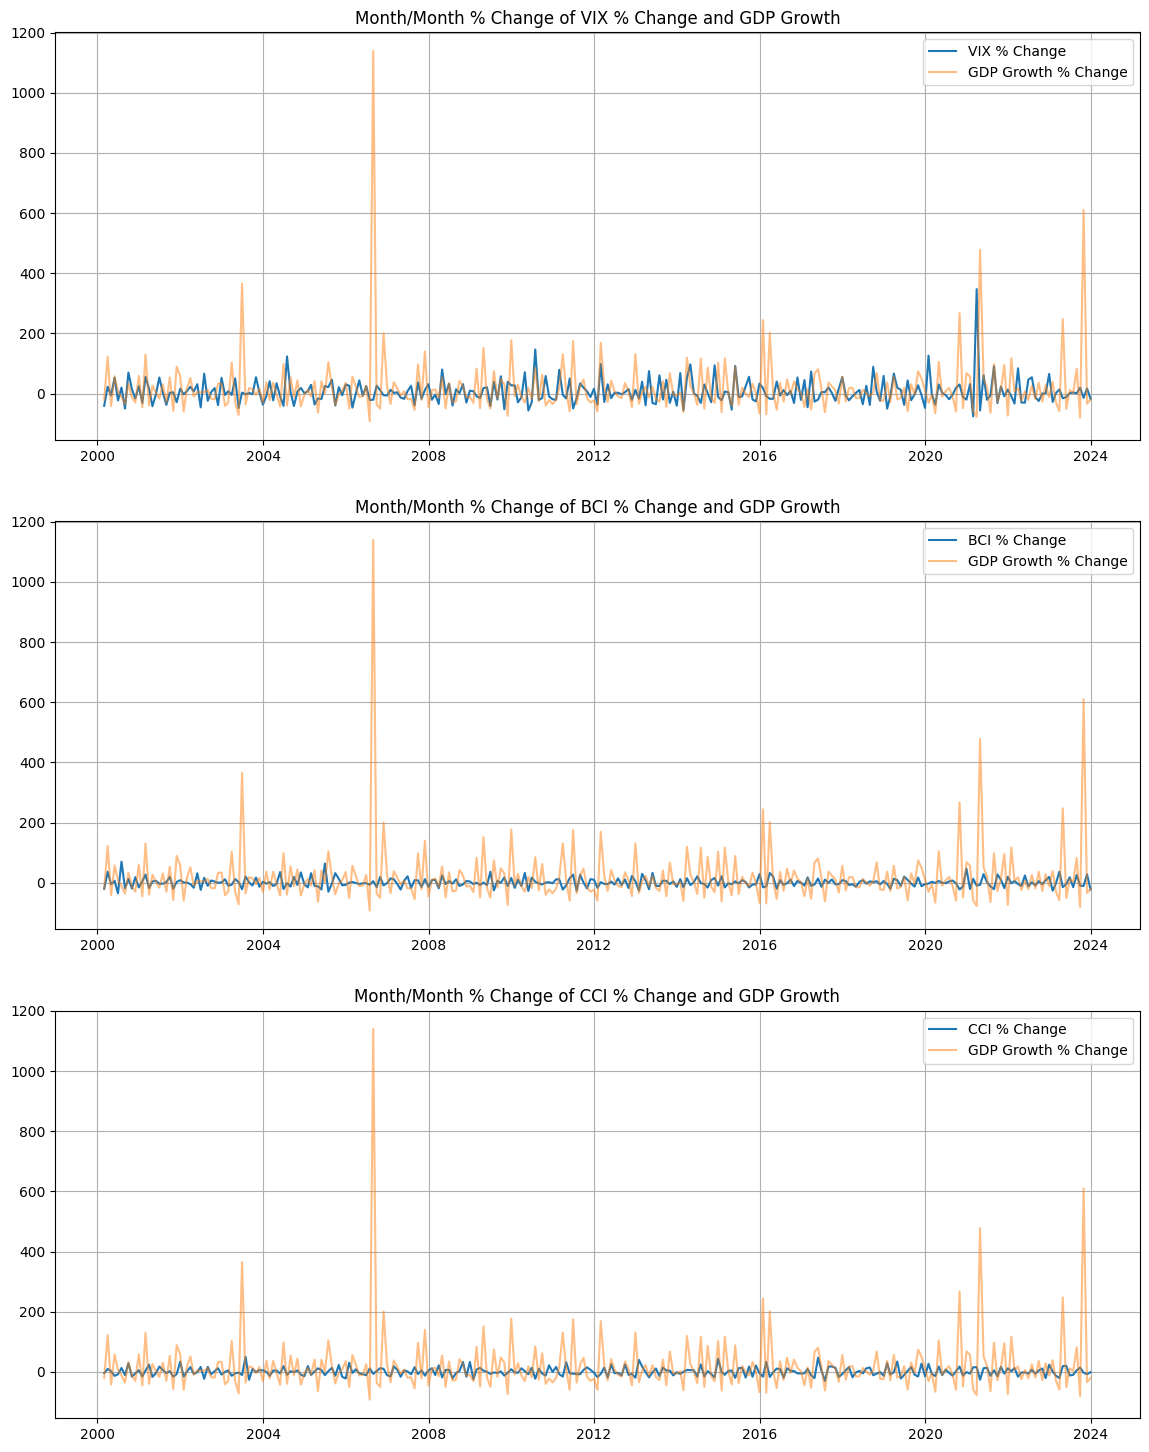

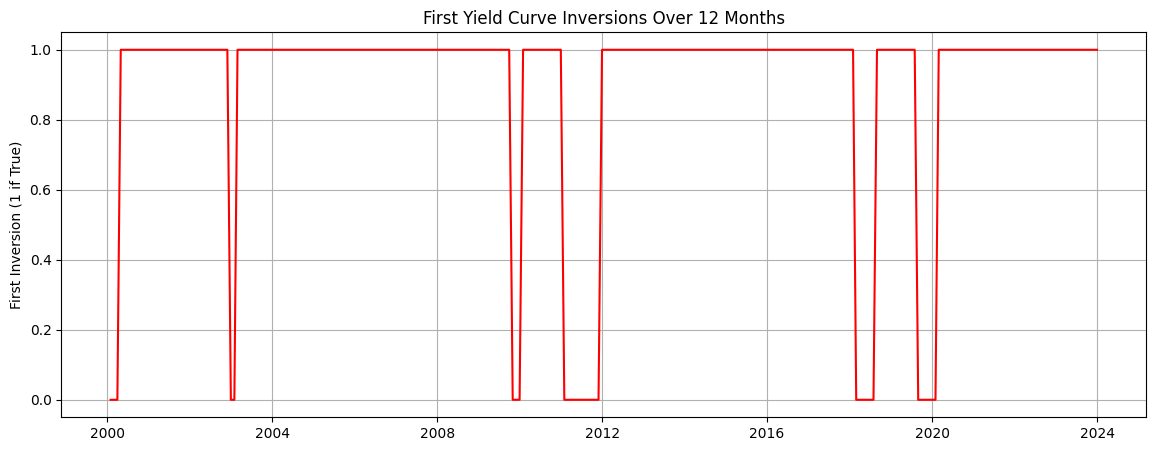

In [460]:
import matplotlib.pyplot as plt

# Calculate month-to-month percentage changes
for column in ['VIX', 'BCI', 'CCI', 'GDP Growth']:
    data[column + ' % Change'] = data[column].pct_change() * 100

# Identify first yield curve inversions within a 12-month rolling window
data['First YC Inversion'] = (data['Yield Curve Inversion'].diff() == 1).astype(int)
data['12M First YC Inversion'] = data['First YC Inversion'].rolling(window=12, min_periods=1).max()

# Plotting the % changes with GDP Growth
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18))
variables = ['VIX % Change', 'BCI % Change', 'CCI % Change']

for ax, var in zip(axes, variables):
    ax.plot(data.index, data[var], label=var)
    ax.plot(data.index, data['GDP Growth % Change'], label='GDP Growth % Change', alpha=0.5)
    ax.set_title(f'Month/Month % Change of {var} and GDP Growth')
    ax.legend()
    ax.grid(True)

# Plotting Yield Curve Inversions
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(data.index, data['12M First YC Inversion'], label='First YC Inversion (12M)', color='red')
ax.set_title('First Yield Curve Inversions Over 12 Months')
ax.set_ylabel('First Inversion (1 if True)')
ax.grid(True)

plt.show()



In [461]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the predictors
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

# PCA transformation
pca = PCA(n_components=2)
principal_components = pca.fit_transform(predictors_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA Component Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()


ValueError: could not convert string to float: 'Federal Funds Rate'

                    Robust linear Model Regression Results                    
Dep. Variable:             GDP Growth   No. Observations:                  288
Model:                            RLM   Df Residuals:                      284
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 12 May 2024                                         
Time:                        13:23:49                                         
No. Iterations:                    14                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.54

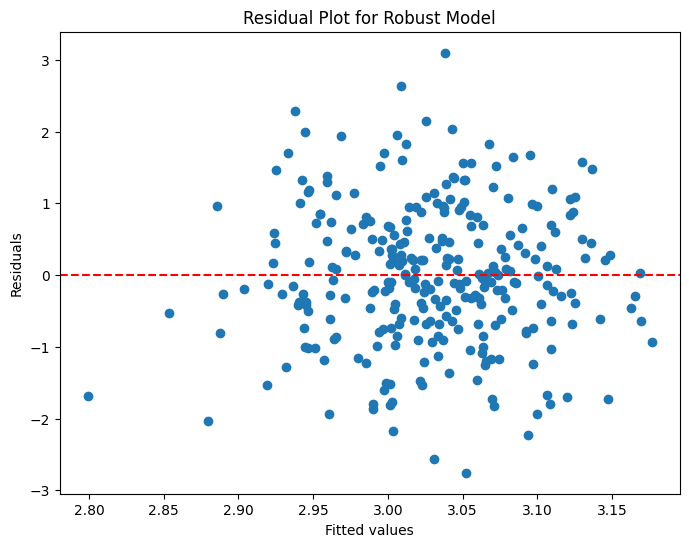

<Figure size 800x600 with 0 Axes>

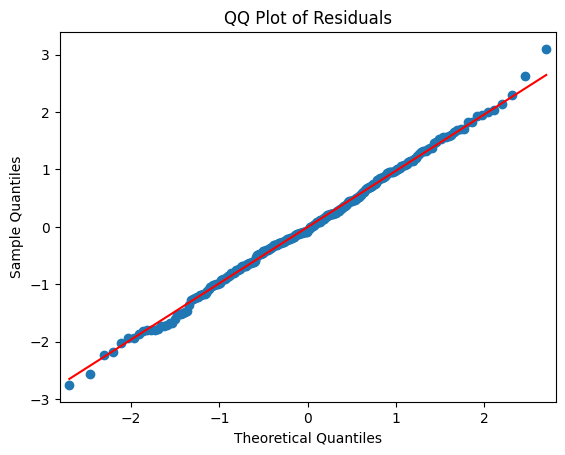

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Assuming 'Confidence Index' needs to be calculated first
data['Confidence Index'] = (data['BCI'] + data['CCI']) / 2

# Robust regression
X = sm.add_constant(data[['Yield Curve Inversion', 'VIX', 'Confidence Index']])
y = data['GDP Growth']
robust_model = sm.RLM(y, X).fit()
print(robust_model.summary())

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(robust_model.fittedvalues, robust_model.resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Robust Model')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# QQ plot for residual normality check
plt.figure(figsize=(8, 6))
qqplot(robust_model.resid, line='s')
plt.title('QQ Plot of Residuals')
plt.show()


In [ ]:
#IV for unemployment rate
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'Unemployment Rate'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:      Unemployment Rate   R-squared:                       0.001
Model:                         IV2SLS   Adj. R-squared:                 -0.002
Method:                     Two Stage   F-statistic:                 2.685e-07
                        Least Squares   Prob (F-statistic):               1.00
Date:                Sun, 12 May 2024                                         
Time:                        13:23:49                                         
No. Observations:                 288                                         
Df Residuals:                     286                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9608     27.861      0.178      0.8

In [ ]:
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'Federal Funds Rate'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:     Federal Funds Rate   R-squared:                      -1.650
Model:                         IV2SLS   Adj. R-squared:                 -1.659
Method:                     Two Stage   F-statistic:                    0.1920
                        Least Squares   Prob (F-statistic):              0.662
Date:                Sun, 12 May 2024                                         
Time:                        13:23:49                                         
No. Observations:                 288                                         
Df Residuals:                     286                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5376      4.663      0.973      0.3

In [ ]:
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'Yield Curve Inversion'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                            IV2SLS Regression Results                            
Dep. Variable:     Yield Curve Inversion   R-squared:                      -3.973
Model:                            IV2SLS   Adj. R-squared:                 -3.990
Method:                        Two Stage   F-statistic:                    0.4616
                           Least Squares   Prob (F-statistic):              0.497
Date:                   Sun, 12 May 2024                                         
Time:                           13:23:49                                         
No. Observations:                    288                                         
Df Residuals:                        286                                         
Df Model:                              1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7056 

In [ ]:
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'VIX'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:                    VIX   R-squared:                     -31.925
Model:                         IV2SLS   Adj. R-squared:                -32.040
Method:                     Two Stage   F-statistic:                  0.001859
                        Least Squares   Prob (F-statistic):              0.966
Date:                Sun, 12 May 2024                                         
Time:                        13:23:49                                         
No. Observations:                 288                                         
Df Residuals:                     286                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5608   1920.572      0.054      0.9

In [ ]:
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'BCI'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:                    BCI   R-squared:                      -6.771
Model:                         IV2SLS   Adj. R-squared:                 -6.798
Method:                     Two Stage   F-statistic:                   0.07752
                        Least Squares   Prob (F-statistic):              0.781
Date:                Sun, 12 May 2024                                         
Time:                        13:23:50                                         
No. Observations:                 288                                         
Df Residuals:                     286                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.2231    301.504      0.611      0.5

In [ ]:
from statsmodels.api import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS

# Let's assume 'Unemployment Rate' is the endogenous variable and 'GDP Growth' is the dependent variable
endogenous_variable = 'CCI'
dependent_variable = 'GDP Growth'

# Generating a random instrumental variable
instrument = np.random.normal(0, 1, len(data))

# Setting up IV regression
iv_model = IV2SLS(endog=data[endogenous_variable],
                  exog=sm.add_constant(data[[dependent_variable]]),
                  instrument=sm.add_constant(instrument)).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:                    CCI   R-squared:                      -5.202
Model:                         IV2SLS   Adj. R-squared:                 -5.224
Method:                     Two Stage   F-statistic:                    0.1817
                        Least Squares   Prob (F-statistic):              0.670
Date:                Sun, 12 May 2024                                         
Time:                        13:23:50                                         
No. Observations:                 288                                         
Df Residuals:                     286                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1996    171.111      0.165      0.8

In [ ]:
print(data.columns)


Index(['Federal Funds Rate', 'Unemployment Rate', 'Yield Curve Inversion',
       'VIX', 'BCI', 'CCI', 'GDP Growth', 'PC1', 'PC2', 'VIX % Change',
       'BCI % Change', 'CCI % Change', 'GDP Growth % Change',
       'First YC Inversion', '12M First YC Inversion', 'Confidence Index'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm

# Calculate Month/Month Percentage Changes
data_pct_change = data.pct_change()

# Identify the Date of the First Yield Curve Inversion (if available)
if 'Yield Curve Inversion' in data.columns:
    data['First YC Inversion'] = data['Yield Curve Inversion'].groupby((data['Yield Curve Inversion'] != data['Yield Curve Inversion'].shift()).cumsum()).transform('idxmin')
    data['First YC Inversion'] = data['First YC Inversion'].dt.to_period('M')  # Convert to period (month)
    data['Months Since First YC Inversion'] = (data.index.to_period('M').astype('int64') - data['First YC Inversion'].astype('int64')).astype(int)
    data['12M First YC Inversion'] = data['Months Since First YC Inversion'].rolling(window=12, min_periods=1).min()

# Define the causality test function
def run_causality_test(dependent, predictors):
    for predictor in predictors:
        print(f"Causality Test between {dependent} and {predictor}:")
        granger_test_result = grangercausalitytests(data[[dependent, predictor]], maxlag=2, verbose=True)
        print()

# Define predictors
predictors = ['Federal Funds Rate', 'Unemployment Rate', 'VIX', 'BCI', 'CCI']

# Run Granger Causality Test
run_causality_test('GDP Growth', predictors)

# Perform Regression Analysis
X = data[predictors]
X = sm.add_constant(X)  # Add constant term
y = data['GDP Growth']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


Causality Test between GDP Growth and Federal Funds Rate:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4670  , p=0.4949  , df_denom=284, df_num=1
ssr based chi2 test:   chi2=0.4719  , p=0.4921  , df=1
likelihood ratio test: chi2=0.4716  , p=0.4923  , df=1
parameter F test:         F=0.4670  , p=0.4949  , df_denom=284, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3745  , p=0.6879  , df_denom=281, df_num=2
ssr based chi2 test:   chi2=0.7624  , p=0.6830  , df=2
likelihood ratio test: chi2=0.7614  , p=0.6834  , df=2
parameter F test:         F=0.3745  , p=0.6879  , df_denom=281, df_num=2

Causality Test between GDP Growth and Unemployment Rate:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2095  , p=0.0743  , df_denom=284, df_num=1
ssr based chi2 test:   chi2=3.2434  , p=0.0717  , df=1
likelihood ratio test: chi2=3.2252  , p=0.0725  , df=1
parameter F test:         F=3.2095  , p=0.0743  , d

c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

In [463]:
# Machine Learning - Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = data[['VIX', 'BCI', 'CCI']]
y = data['GDP Growth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 1.3665114224666772


In [464]:
# Time Series Analysis - Vector Autoregression (VAR) Model
model = VAR(data[['GDP Growth', 'VIX', 'BCI', 'CCI']])
var_results = model.fit()
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, May, 2024
Time:                     13:37:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    12.7625
Nobs:                     287.000    HQIC:                   12.6097
Log likelihood:          -3403.76    FPE:                    270347.
AIC:                      12.5074    Det(Omega_mle):         252300.
--------------------------------------------------------------------
Results for equation GDP Growth
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 2.942384         0.877510            3.353           0.001
L1.GDP Growth        -0.062701         0.059537           -1.053           0.292
L1.VIX                0.006565         0.012216        

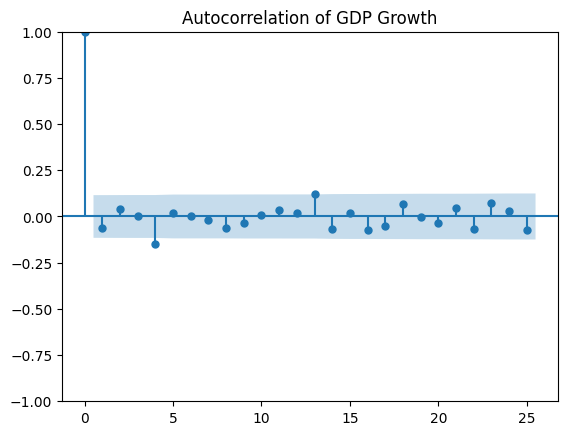

                               SARIMAX Results                                
Dep. Variable:             GDP Growth   No. Observations:                  288
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -404.881
Date:                Sun, 12 May 2024   AIC                            815.763
Time:                        13:38:05   BIC                            826.741
Sample:                    01-31-2000   HQIC                           820.163
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0591      0.057     -1.039      0.299      -0.171       0.052
ma.L1         -0.9998      0.323     -3.097      0.002      -1.633      -0.367
sigma2         0.9642      0.321      3.000      0.0

In [466]:

# Time Series Analysis - Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.mediation import Mediation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
plot_acf(data['GDP Growth'])
plt.title('Autocorrelation of GDP Growth')
plt.show()

# Time Series Analysis - ARIMA Model
model = ARIMA(data['GDP Growth'], order=(1, 1, 1))
arima_results = model.fit()
print(arima_results.summary())

In [468]:
from statsmodels.stats.mediation import Mediation

# Define the formula for mediation analysis
formula = "GDP_Growth ~ Yield_Curve_Inversion + VIX + BCI + CCI"

# Perform mediation analysis
mediation = Mediation(data, formula, treat="Yield_Curve_Inversion", mediator=["VIX", "BCI", "CCI"], outcome="GDP_Growth")
mediation_results = mediation.fit()
print(mediation_results.summary())

ValueError: cannot infer mediator name without formula